# Data Viewer

What data to present

# For every file

- Bar graph of most held keys
- Bar graph of most key up keys
- 2D Histogram of mouse information

# Aggregate, Comparing Games to Active and then Passive

## Key hold times for each key

X-Axis: Keys, sorted by median hold times

Y-Axis: Violin and also box plot of the distributions of hold times of each key
every minute.

## Key up counts for each key

Same as above, but key up counts

## Left mouse hold times, right mouse hold times

Bar graph

X-Axis: Label (Game, Active, Passive)

Y-Axis: Boxplot and violinplot of left and right mouse hold times every minute

## Left mouse up times, right mouse up times

Same as above, but mouseup counts instead

## Scroll times

Same as above, but scroll event counts

## 2D Histogram

Compare passive, active, and game in three different 2D histograms

These should show mouse positions

There are many different displays with different resolutions, so normalize this
data to the size of the primary monitor.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from json import loads

In [2]:
path = "test_game.txt"
COLOR = 'tomato'
TITLE_ADDITION = ' for game'

# Verify blocks

In [3]:
import hashlib

def verify_blocks(blocks: list[str]) -> bool:
    content = "\n\n".join(blocks)

    # Get rid of last line with the hash
    content, hashline = content.rsplit("\n", 1)

    # Hash content, compare with hashline
    actual_hash = hashlib.sha256(content.encode('utf-8')).hexdigest()

    return hashline == "Hash|" + actual_hash

# Bins to list

Turns bins with counts into an list of data

bin: counts

Performance is O(N^2) which indicates that this could be improved further

Although since it's only used for data processing and not production it is a good enough; we don't need to prematurely optimize

In [4]:
def bin_to_list(dict) -> list[int]:
    result = []

    for key in dict.keys():
        key = key

        for x in range(dict[key]):
            result.append(key)

    return result


# Scale data

Scales data to between 0-1 inclusive given min, max, and data

In [5]:
def scale(x, min, max):

    if ((1/(max-min))*(x-min)) > 1:
        print(x)
    return (1/(max-min))*(x-min)

# Viewing data for a single file

1300
1300
1300
Block index 54 is tampered


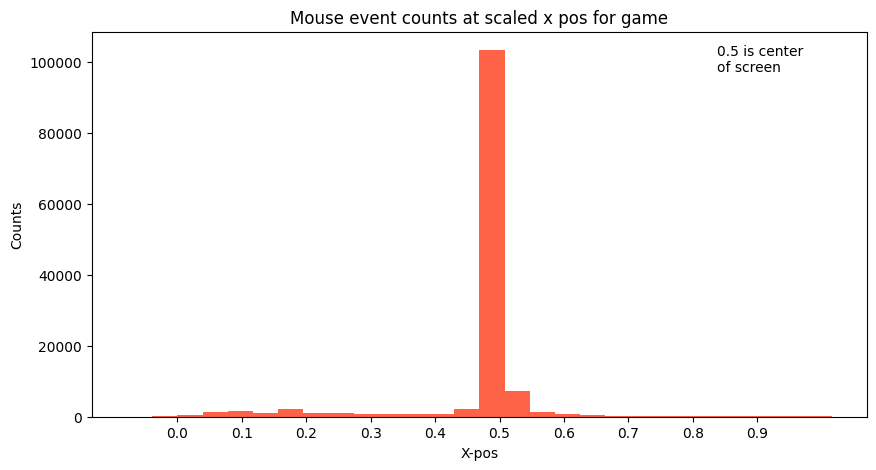

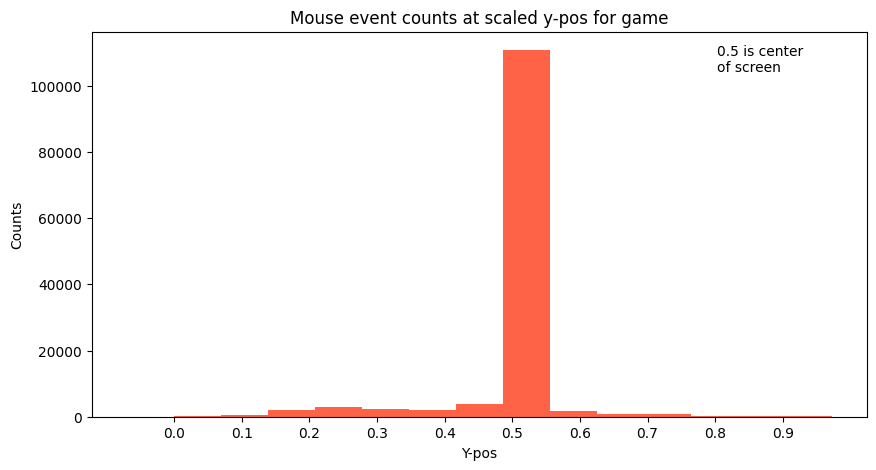

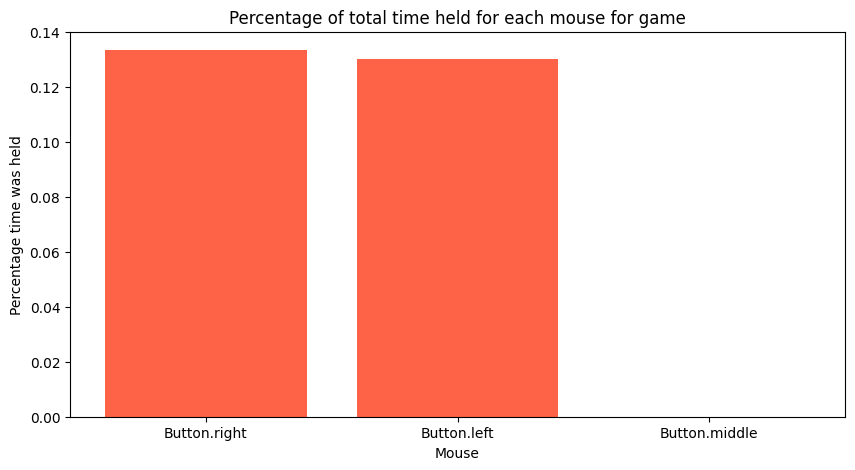

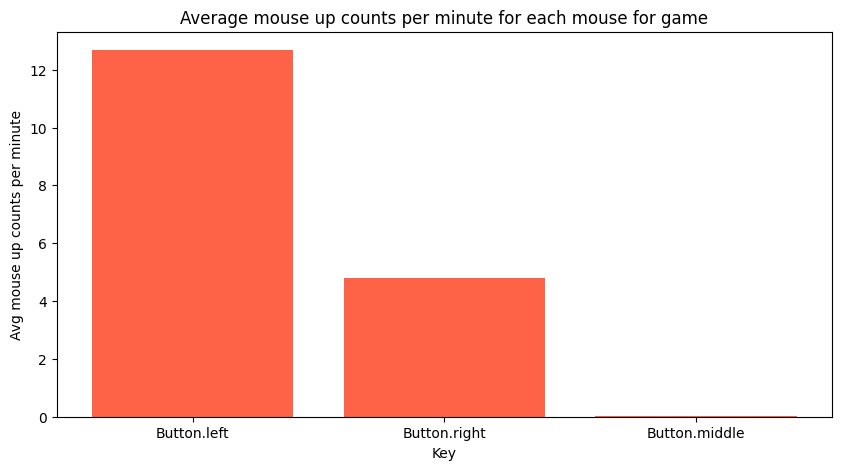

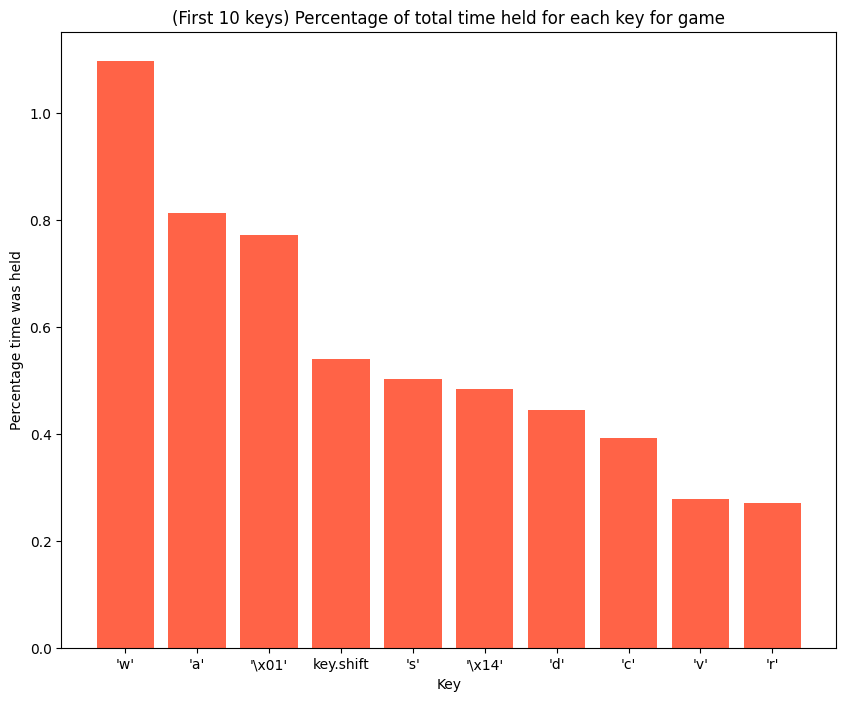

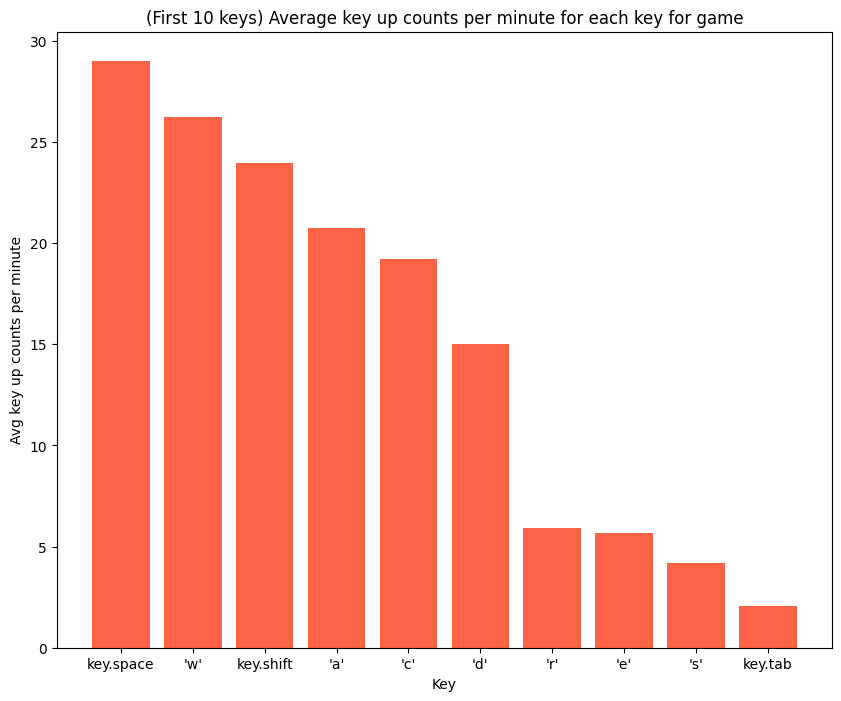

In [6]:
file = open(path, "r")

contents = file.read()

file.close()

blocks = contents.split("\n\n")

x_pos = {}
y_pos = {}
total_key_time_held = {} # Percentage of time held, so raw key time held in seconds divided by total seconds
total_keyup = {} # Key up counts per minute
total_mouse_held = {}
total_mouseup = {}

# Get monitor information
monitor_min_x = 0
monitor_max_x = 0



monitor_min_y = 0
monitor_max_y = 0

minutes = len(blocks) - 2

lines = blocks[0].split('\n')

for line in lines:
    if line.startswith('Monitor') and bool(line[line.index('is_primary=')+11:-1]): # second part is checking if its primary
        monitor_min_x = int(line[line.index('x=') + 2:line.index(', y=')])
        monitor_max_x = monitor_min_x + int(line[line.index('width=') + 6:line.index(', height=')])

        monitor_min_y = int(line[line.index('y=') + 2:line.index(', width=')])
        monitor_max_y = monitor_min_y + int(line[line.index('height=') + 7:line.index(', width_mm=')])
        break

for x in range(1, len(blocks)):
    if not verify_blocks(blocks[:x+1]):
        print("Block index " + str(x) + " is tampered")
        continue
        # Don't break because it might just be some blank line

    raw_block = blocks[x]
    raw_lines = raw_block.split('\n')

    block = {}
    for line in raw_lines:
        key, value = line.split('|')

        block[key] = value
    
    # mouse histogram
    block['x_histogram'] = loads(block['x_histogram'])
    block['y_histogram'] = loads(block['y_histogram'])

    for bin_raw in block['x_histogram'].keys():
        bin = scale(int(bin_raw), monitor_min_x, monitor_max_x)

        if not bin in x_pos.keys():
            x_pos[bin] = block['x_histogram'][bin_raw]
        else:
            x_pos[bin] += block['x_histogram'][bin_raw]
    
    for bin_raw in block['y_histogram'].keys():
        bin = scale(int(bin_raw), monitor_min_y, monitor_max_y)

        if not bin in y_pos.keys():
            y_pos[bin] = block['y_histogram'][bin_raw]
        else:
            y_pos[bin] += block['y_histogram'][bin_raw]
    
    # keys
    block['key_time_held'] = loads(block['key_time_held'])
    for key_raw in block['key_time_held'].keys():
        key = key_raw.lower()

        if not key in total_key_time_held.keys():
            total_key_time_held[key] = block['key_time_held'][key_raw] / ((minutes) * 60)
        else:
            total_key_time_held[key] += block['key_time_held'][key_raw] / ((minutes) * 60)
    


    block['keyup_counts'] = loads(block['keyup_counts'])
    for key_raw in block['keyup_counts'].keys():
        key = key_raw.lower()

        if not key in total_keyup.keys():
            total_keyup[key] = block['keyup_counts'][key_raw] / (minutes)
        else:
            total_keyup[key] += block['keyup_counts'][key_raw] / (minutes)
    
    # mouse
    block['time_mouse_held'] = loads(block['time_mouse_held'])
    for mouse in block['time_mouse_held'].keys():
        if not mouse in total_mouse_held.keys():
            total_mouse_held[mouse] = block['time_mouse_held'][mouse] / ((minutes) * 60)
        else:
            total_mouse_held[mouse] += block['time_mouse_held'][mouse] / ((minutes) * 60)
    

    block['mouseup_counts'] = loads(block['mouseup_counts'])
    for mouse in block['mouseup_counts'].keys():
        if not mouse in total_mouseup.keys():
            total_mouseup[mouse] = block['mouseup_counts'][mouse] / (minutes)
        else:
            total_mouseup[mouse] += block['mouseup_counts'][mouse] / (minutes)

# X-pos for mouse events
x_list = bin_to_list(x_pos)
x_bins = list(x_pos.keys())
x_bins = sorted(x_bins)
plt.figure(figsize=[10,5])
plt.title('Mouse event counts at scaled x pos' + TITLE_ADDITION)
plt.xlabel('X-pos')
plt.ylabel('Counts')
plt.figtext(.75, .8, "0.5 is center\nof screen")
plt.hist(x_list, bins=x_bins, color=COLOR)

# Setting ticks to be every 0.1
axes = plt.gca()
start, end = axes.get_xlim()
axes.xaxis.set_ticks(np.arange(0, 1, 0.1))


# Y-pos for mouse events
y_list = bin_to_list(y_pos)
y_bins = list(y_pos.keys())
y_bins.append(max(y_bins))
y_bins = sorted(y_bins)
plt.figure(figsize=[10,5])
plt.title('Mouse event counts at scaled y-pos' + TITLE_ADDITION)
plt.xlabel('Y-pos')
plt.ylabel('Counts')
plt.figtext(.75, .8, "0.5 is center\nof screen")
plt.hist(y_list, bins=y_bins, color=COLOR)

# Setting ticks to be every 0.1
axes = plt.gca()
start, end = axes.get_xlim()
axes.xaxis.set_ticks(np.arange(0, 1, 0.1))




# Percentage each mouse was held
total_mouse_held = dict(sorted(total_mouse_held.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=[10, 5])
plt.xlabel("Mouse")
plt.ylabel("Percentage time was held")
plt.title("Percentage of total time held for each mouse" + TITLE_ADDITION)
plt.bar(total_mouse_held.keys(), total_mouse_held.values(), color=COLOR)

plt.show()




# Key up counts per minute for mouse up
total_mouseup = dict(sorted(total_mouseup.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=[10, 5])
plt.xlabel("Key")
plt.ylabel("Avg mouse up counts per minute")
plt.title("Average mouse up counts per minute for each mouse" + TITLE_ADDITION)
plt.bar(total_mouseup.keys(), total_mouseup.values(), color=COLOR)

plt.show()






# Percentage each key was held
total_key_time_held = dict(sorted(total_key_time_held.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=[10, 8])
plt.xlabel("Key")
plt.ylabel("Percentage time was held")
plt.title("(First 10 keys) Percentage of total time held for each key" + TITLE_ADDITION)
plt.bar(list(total_key_time_held.keys())[:10], list(total_key_time_held.values())[:10], color=COLOR)

plt.show()




# Key up counts per minute for each key
total_keyup = dict(sorted(total_keyup.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=[10, 8])
plt.xlabel("Key")
plt.ylabel("Avg key up counts per minute")
plt.title("(First 10 keys) Average key up counts per minute for each key" + TITLE_ADDITION)
plt.bar(list(total_keyup.keys())[:10], list(total_keyup.values())[:10], color=COLOR)

plt.show()